In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns

## Cargar datos

In [2]:
# Cargar el archivo TIFF Sentinel 2
file_path = '/Users/ortega/Downloads/clase/train/combinado.tif'
src = rasterio.open(file_path)

## Información general del raster

In [3]:
# Obtener dimensiones del archivo
width = src.width
height = src.height
bands = src.count

# Imprimir las dimensiones y el número de bandas
print(f"Dimensiones datos (ancho x alto): {width} x {height}")
print(f"Número de bandas: {bands}")

Dimensiones datos (ancho x alto): 3000 x 3000
Número de bandas: 15


In [4]:
# Banda 1 corresponde a las areas etiquetadas (Etiquetas)
src.read(1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Visualización

### RGB (bandas 4, 3, 2)

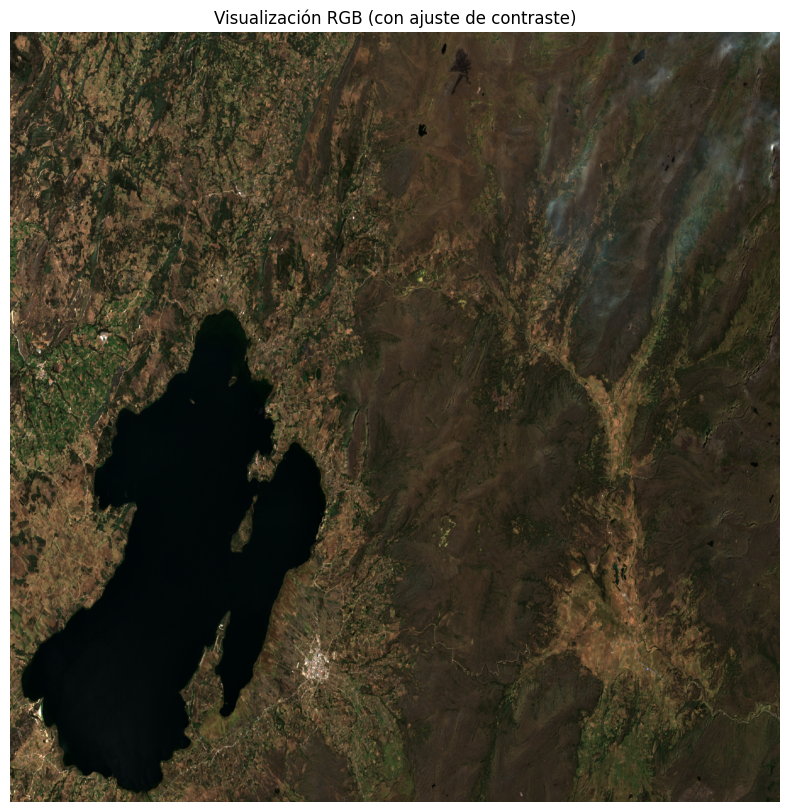

In [5]:
red = src.read(5)  # Banda 4 (Rojo)
green = src.read(4)  # Banda 3 (Verde)
blue = src.read(3)  # Banda 2 (Azul)

# Reemplazar valores no válidos (NaN o infinitos) por 0
red = np.nan_to_num(red, nan=0, posinf=0, neginf=0)
green = np.nan_to_num(green, nan=0, posinf=0, neginf=0)
blue = np.nan_to_num(blue, nan=0, posinf=0, neginf=0)

# Ajuste de contraste: Clipping a un rango adecuado para imágenes Sentinel-2
red = np.clip(red, 0, 0.3)
green = np.clip(green, 0, 0.3)
blue = np.clip(blue, 0, 0.3)

# Normalizar al rango [0, 255] y convertir a uint8
red = ((red / 0.3) * 255).astype(np.uint8)
green = ((green / 0.3) * 255).astype(np.uint8)
blue = ((blue / 0.3) * 255).astype(np.uint8)

# Crear una imagen RGB combinando las bandas
rgb_image = np.dstack((red, green, blue))

# Mostrar la imagen en RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("Visualización RGB (con ajuste de contraste)")
plt.show()

### NDWI

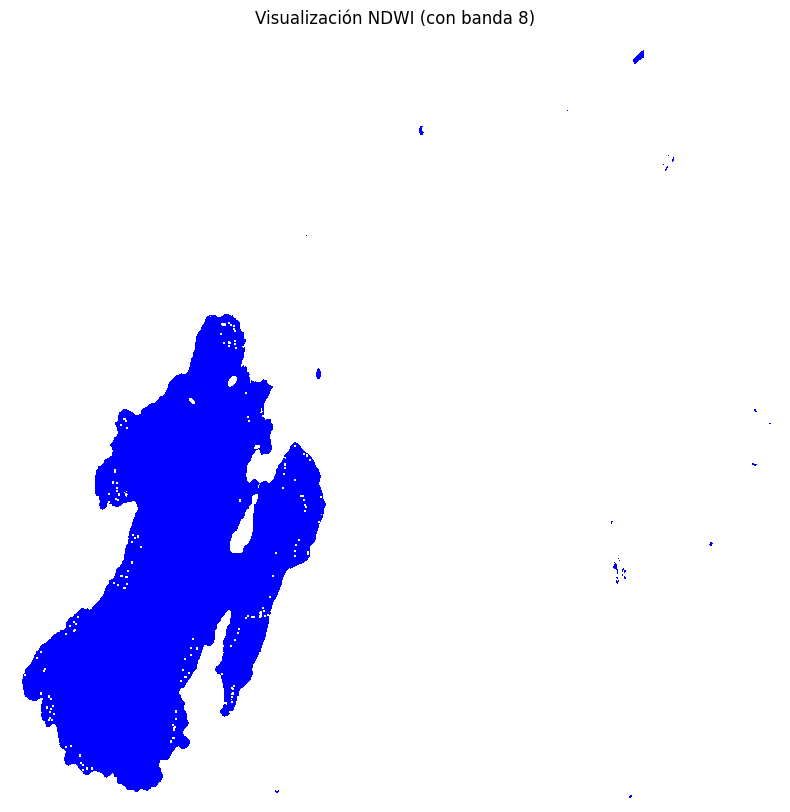

In [6]:
band1 = src.read(14)

# Colores para valores negativos y positivos
cmap = ListedColormap(["white", "blue"])

# Mostrar la banda en la escala especificada
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap=cmap, vmin=-1, vmax=1)
plt.title("Visualización NDWI (con banda 8)")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

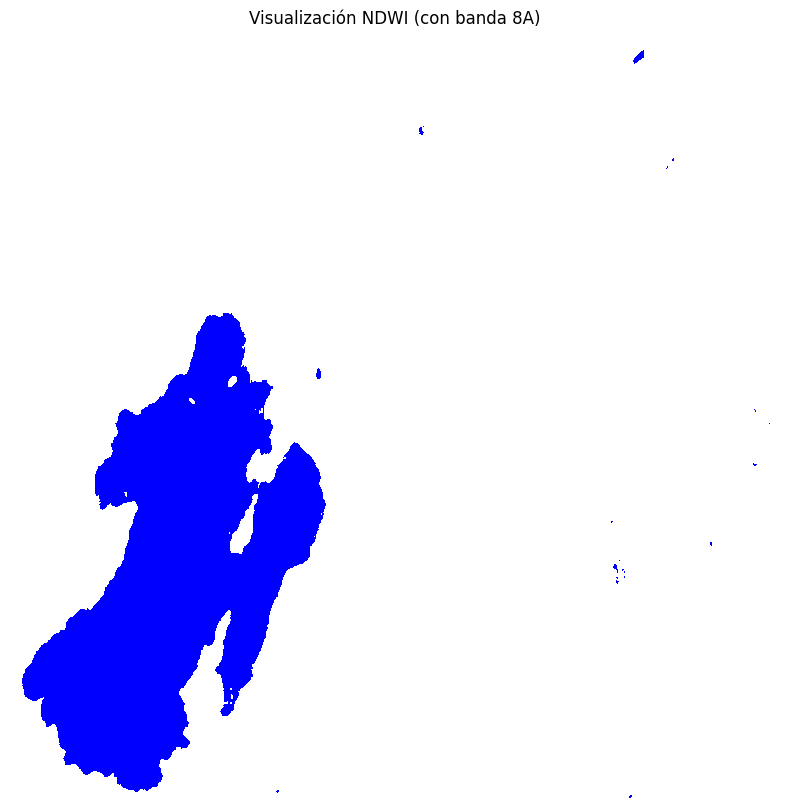

In [7]:
band1 = src.read(15)

# Colores para valores negativos y positivos
cmap = ListedColormap(["white", "blue"])

# Mostrar la banda en la escala especificada
plt.figure(figsize=(10, 10))
plt.imshow(band1, cmap=cmap, vmin=-1, vmax=1)
plt.title("Visualización NDWI (con banda 8A)")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

### Areas etiquetadas

In [8]:
etiquetas = src.read(1)

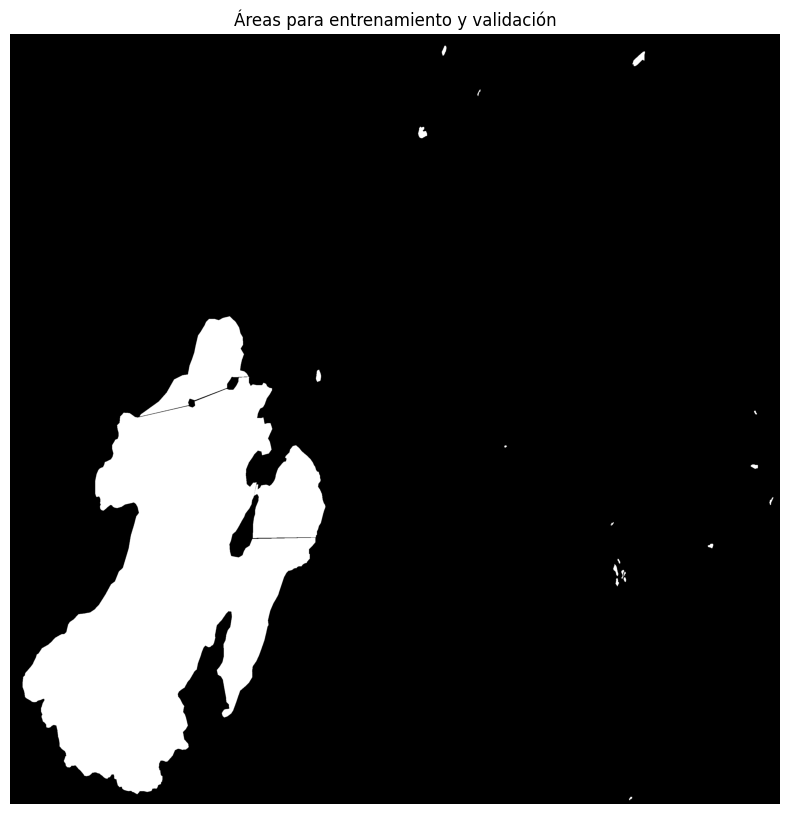

In [9]:
# Asignar un valor constante a todos los valores diferentes de 0
etiquetas_ = np.where(etiquetas > 0, 1, etiquetas)
# Visualizar la banda modificada en escala de grises
plt.figure(figsize=(10, 10))
plt.imshow(etiquetas_, cmap='gray')
plt.title("Áreas para entrenamiento y validación")
plt.axis('off')  # Opcional: Ocultar los ejes
plt.show()

Banda 2 (Áreas para entrenamiento y validación) - Min: 1.0, Max: 24.0, Mean: 2.0781357288360596


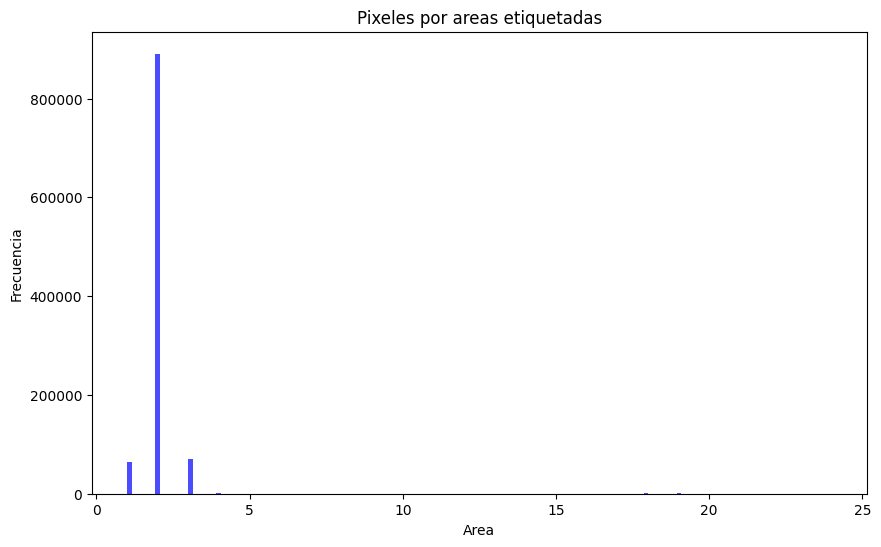

In [10]:
band2_nonzero = etiquetas[etiquetas != 0]
# Calcular estadísticas básicas para la última banda
min_value = np.min(band2_nonzero)
max_value = np.max(band2_nonzero)
mean_value = np.mean(band2_nonzero)

# Imprimir estadísticas
print(f"Banda 2 (Áreas para entrenamiento y validación) - Min: {min_value}, Max: {max_value}, Mean: {mean_value}")

# Crear histograma para la última banda
plt.figure(figsize=(10, 6))
plt.hist(band2_nonzero.flatten(), bins=150, color='blue', alpha=0.7)
plt.title(f'Pixeles por areas etiquetadas')
plt.xlabel('Area')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

## Preparación de los datos

In [11]:
ndwi_8 = src.read(14).flatten()  # NDWI banda 3 y 8
ndwi_8A = src.read(15).flatten()  # NDWI banda 3 y 8A
nir = src.read(9).flatten()  # Infrarrojo cercano (banda 8)
labels = src.read(1).flatten()  # Áreas de interés (etiquetas)
rojo = src.read(5).flatten() # Rojo

In [12]:
# Crear un DataFrame con las características y las etiquetas
df = pd.DataFrame({
    'NDWI_8': ndwi_8,
    'NDWI_8A': ndwi_8A,
    'NIR': nir,
    'rojo': rojo,
    'cuerpo_agua': labels,
})

In [13]:
df

,NDWI_8,NDWI_8A,NIR,rojo,cuerpo_agua
0,-0.704647,-0.667313,0.2476,0.0384,0.0
1,-0.664408,-0.672501,0.2088,0.0436,0.0
2,-0.640212,-0.660989,0.1860,0.0346,0.0
3,-0.640212,-0.660989,0.1860,0.0346,0.0
4,-0.725916,-0.736751,0.1908,0.0332,0.0
...,...,...,...,...,...
8999995,-0.659259,-0.675167,0.2016,0.0416,0.0
8999996,-0.681649,-0.698202,0.2039,0.0407,0.0
8999997,-0.681649,-0.698202,0.2039,0.0407,0.0
8999998,-0.677365,-0.700861,0.1986,0.0364,0.0


In [14]:
df['cuerpo_agua'] = np.where(df['cuerpo_agua'] > 0, True, False)

In [15]:
df.head()

,NDWI_8,NDWI_8A,NIR,rojo,cuerpo_agua
0,-0.704647,-0.667313,0.2476,0.0384,False
1,-0.664408,-0.672501,0.2088,0.0436,False
2,-0.640212,-0.660989,0.1860,0.0346,False
3,-0.640212,-0.660989,0.1860,0.0346,False
4,-0.725916,-0.736751,0.1908,0.0332,False


## Estadistica descriptiva

In [16]:
df.describe(percentiles=[0.01,.03,.05,.07,.08,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99])

,NDWI_8,NDWI_8A,NIR,rojo
count,8.999674e+06,8.999993e+06,8.999688e+06,8.999917e+06
mean,-3.923511e-01,-4.143899e-01,1.974972e-01,6.654752e-02
std,4.861583e-01,4.980826e-01,9.940402e-02,3.804873e-02
min,-1.229996e+02,-1.430002e+02,-9.990000e-02,-1.980000e-02
1%,-7.403367e-01,-7.568766e-01,-6.000000e-04,9.000000e-04
3%,-7.052423e-01,-7.220438e-01,1.200000e-03,2.100000e-03
5%,-6.842105e-01,-7.020921e-01,2.100000e-03,2.700000e-03
7%,-6.681223e-01,-6.869469e-01,2.700000e-03,3.100000e-03
8%,-6.611803e-01,-6.804793e-01,3.000000e-03,3.400000e-03
10%,-6.488550e-01,-6.688851e-01,5.300000e-03,5.300000e-03


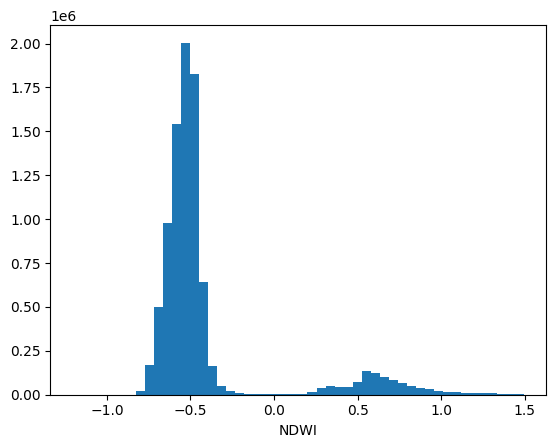

In [17]:
plt.hist(df[(df['NDWI_8']>-1.5) & (df['NDWI_8']<1.5)]['NDWI_8'], bins=50)
plt.xlabel('NDWI')
plt.show()

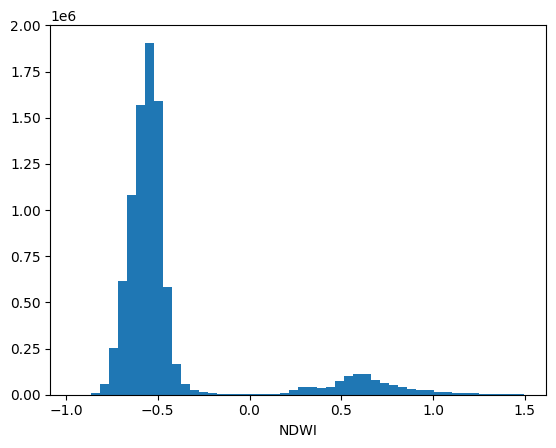

In [18]:
plt.hist(df[(df['NDWI_8A']>-1.5) & (df['NDWI_8A']<1.5)]['NDWI_8A'], bins=50)
plt.xlabel('NDWI')
plt.show()

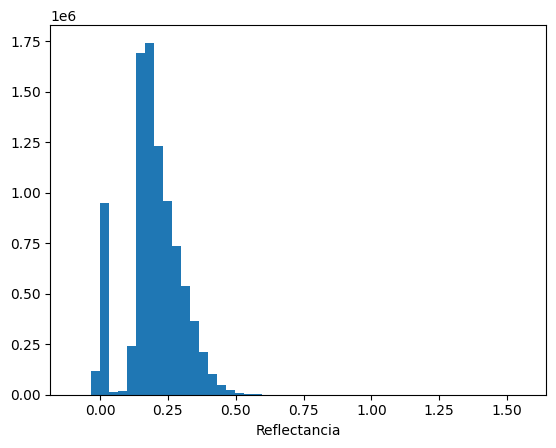

In [19]:
plt.hist(df['NIR'], bins=50)
plt.xlabel('Reflectancia')
plt.show()

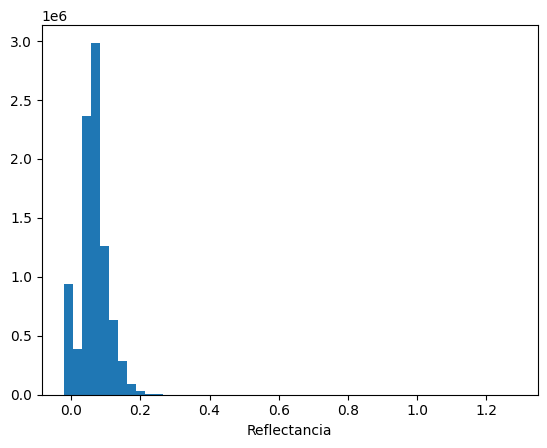

In [20]:
plt.hist(df['rojo'], bins=50)
plt.xlabel('Reflectancia')
plt.show()

In [21]:
df = df[(df['NDWI_8']>-1.5) & (df['NDWI_8']<1.5) & (df['NDWI_8A']>-1.5) & (df['NDWI_8A']<1.5)]

In [22]:
df.isna().sum()

NDWI_8          0
NDWI_8A         0
NIR             0
rojo           25
cuerpo_agua     0
dtype: int64

In [23]:
df.dropna(inplace=True)

/var/folders/kg/plkd97154_zf916xg8gj219h0000gn/T/ipykernel_25777/1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [24]:
df.describe()

,NDWI_8,NDWI_8A,NIR,rojo
count,8.945180e+06,8.945180e+06,8.945180e+06,8.945180e+06
mean,-4.073943e-01,-4.293061e-01,1.987132e-01,6.695344e-02
std,3.901037e-01,3.931884e-01,9.847495e-02,3.780858e-02
min,-1.202867e+00,-9.615833e-01,-9.990000e-02,-1.980000e-02
25%,-5.870545e-01,-6.096154e-01,1.538000e-01,4.700000e-02
50%,-5.204982e-01,-5.450535e-01,1.938000e-01,6.410000e-02
75%,-4.602473e-01,-4.850829e-01,2.584000e-01,8.560000e-02
max,1.495413e+00,1.495049e+00,1.562400e+00,1.283200e+00


In [25]:
df[['NDWI_8', 'NDWI_8A', 'NIR', 'rojo']].corr()

,NDWI_8,NDWI_8A,NIR,rojo
NDWI_8,1.000000,0.991828,-0.724161,-0.481588
NDWI_8A,0.991828,1.000000,-0.708440,-0.477249
NIR,-0.724161,-0.708440,1.000000,0.716300
rojo,-0.481588,-0.477249,0.716300,1.000000


## Muestreo aleatorio

In [26]:
df['cuerpo_agua'].value_counts()

cuerpo_agua
False    7966774
True      978406
Name: count, dtype: int64

In [27]:
sample_size_per_class = 500000

In [28]:
df_sampled = pd.concat([
    df[df['cuerpo_agua'] == class_value].sample(n=sample_size_per_class, random_state=42, replace=False)
    for class_value in df['cuerpo_agua'].unique()
])

In [29]:
df_sampled['cuerpo_agua'].value_counts()

cuerpo_agua
False    500000
True     500000
Name: count, dtype: int64

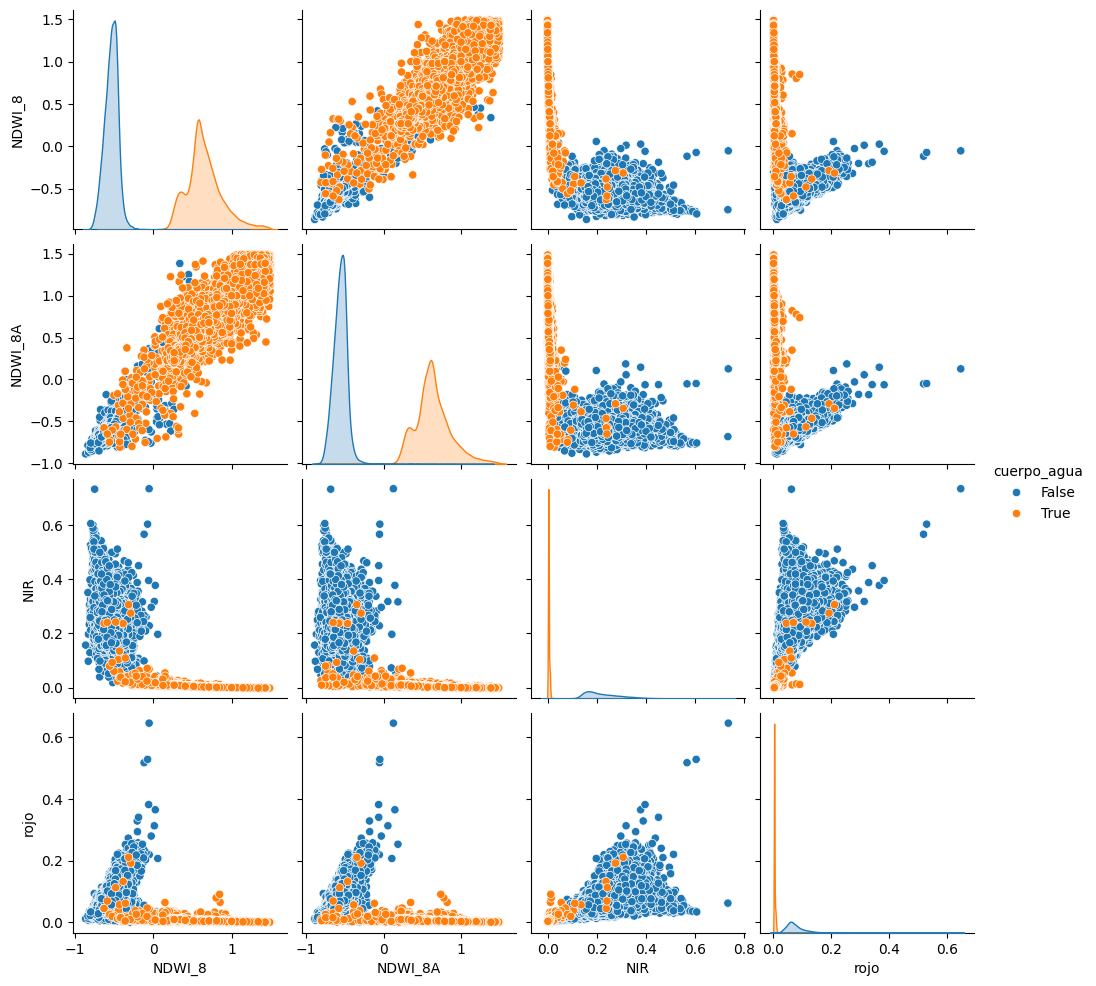

In [42]:
muestra =  pd.concat([
    df[df['cuerpo_agua'] == class_value].sample(n=30000, random_state=42, replace=False)
    for class_value in df['cuerpo_agua'].unique()
])
sns.pairplot(data=muestra, hue="cuerpo_agua")

## Datos de entrenamiento y validación

In [34]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_sampled.drop(['cuerpo_agua', 'NDWI_8', 'NIR'], axis=1)  # Variables independientes
y = df_sampled['cuerpo_agua']               # Variable dependiente

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # stratify=y


In [37]:
X.head()

,NDWI_8A,rojo
7630804,-0.527163,0.0538
1101946,-0.542467,0.1128
3288625,-0.408297,0.1088
2889652,-0.494973,0.0796
8050575,-0.482504,0.0634


In [38]:
y_train.value_counts()

cuerpo_agua
True     450051
False    449949
Name: count, dtype: int64

## SVC

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [36]:
svm_model = SVC(kernel='linear', random_state=42)

In [37]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [38]:
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [39]:
y_pred

array([False,  True,  True, ..., False, False,  True])

In [40]:
print("Exactitud del modelo SVM:", accuracy)
print("\nReporte de clasificación:\n", report)

Exactitud del modelo SVM: 0.99713

Reporte de clasificación:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     50000
        True       1.00      1.00      1.00     50000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



### Frontera de decision

In [52]:
from sklearn.inspection import DecisionBoundaryDisplay

In [72]:
sample_indices = np.random.choice(X_train.index, 100, replace=False)
X_sample = X_train.loc[sample_indices, ['NDWI_8A', 'rojo']]
y_sample = y_train.loc[sample_indices]

<Figure size 1000x600 with 0 Axes>

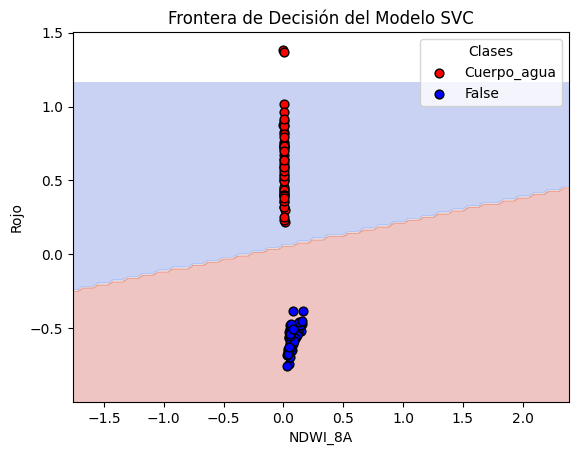

In [73]:
# Usar DecisionBoundaryDisplay para graficar la frontera de decisión
plt.figure(figsize=(10, 6))
DecisionBoundaryDisplay.from_estimator(svm_model, X_sample, response_method="predict", cmap='coolwarm', alpha=0.3)

# Graficar los puntos de datos
# Graficar los puntos de datos de cada clase con etiquetas
plt.scatter(X_sample[y_sample == True]['rojo'], X_sample[y_sample == True]['NDWI_8A'],
            color='red', edgecolor='k', s=40, label='Cuerpo_agua')
plt.scatter(X_sample[y_sample == False]['rojo'], X_sample[y_sample == False]['NDWI_8A'],
            color='blue', edgecolor='k', s=40, label='False')
plt.xlabel('NDWI_8A')
plt.ylabel('Rojo')
plt.title('Frontera de Decisión del Modelo SVC')
plt.legend(title="Clases", loc="upper right") 
plt.show()

### Predicción sobre una nueva imagen

In [49]:
# Cargar el archivo TIFF Sentinel 2
file_path = '/Users/ortega/Downloads/clase/validation/subset_2_of_S2A_MSIL2A_20240125T151711_N0510_R125_T18NYM_20240125T180053_resampled_reprojected.tif'
src_new = rasterio.open(file_path)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


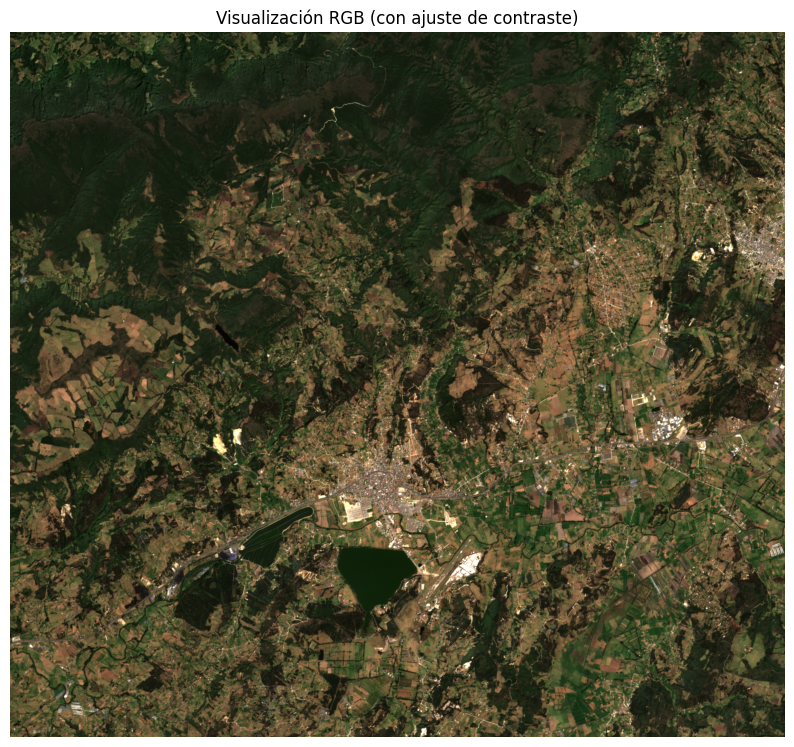

In [50]:
red = src_new.read(4)  # Banda 4 (Rojo)
green = src_new.read(3)  # Banda 3 (Verde)
blue = src_new.read(2)  # Banda 2 (Azul)

# Reemplazar valores no válidos (NaN o infinitos) por 0
red = np.nan_to_num(red, nan=0, posinf=0, neginf=0)
green = np.nan_to_num(green, nan=0, posinf=0, neginf=0)
blue = np.nan_to_num(blue, nan=0, posinf=0, neginf=0)

# Ajuste de contraste: Clipping a un rango adecuado para imágenes Sentinel-2
red = np.clip(red, 0, 0.3)
green = np.clip(green, 0, 0.3)
blue = np.clip(blue, 0, 0.3)

# Normalizar al rango [0, 255] y convertir a uint8
red = ((red / 0.3) * 255).astype(np.uint8)
green = ((green / 0.3) * 255).astype(np.uint8)
blue = ((blue / 0.3) * 255).astype(np.uint8)

# Crear una imagen RGB combinando las bandas
rgb_image = np.dstack((red, green, blue))

# Mostrar la imagen en RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("Visualización RGB (con ajuste de contraste)")
plt.show()

In [51]:
# Leer las bandas necesarias y mantener la estructura 2D
ndwi_8A_new = src_new.read(14)  # NDWI banda 3 y 8A
rojo_new = src_new.read(4)      # Rojo


# Inicializar la matriz de salida con ceros y con la misma forma que la imagen original
predicted_image = np.zeros(ndwi_8A_new.shape, dtype=np.uint8)  # Usamos uint8 porque solo queremos 0 y 1

# Recorrer cada pixel y aplicar las condiciones
for i in range(ndwi_8A_new.shape[0]):
    for j in range(ndwi_8A_new.shape[1]):
        ndwi_value = ndwi_8A_new[i, j]
        rojo_value = rojo_new[i, j]
        
        # Solo predecir si el valor no es NaN y está en el rango
        if not np.isnan(ndwi_value) and -1.5 < ndwi_value < 1.5:
            # Realizar la predicción (se asume que el modelo ya está entrenado)
            input_data = pd.DataFrame([[ndwi_value, rojo_value]], columns=['NDWI_8A', 'rojo'])
            prediction = svm_model.predict(input_data)[0]
            
            # Convertir True/False a 1/0 y asignar al pixel en predicted_image
            predicted_image[i, j] = 1 if prediction else 0

# Guardar la imagen predicha como un archivo .tif georreferenciado
metadata = src_new.meta.copy()
metadata.update({
    'count': 1,             # Solo una banda de predicción
    'dtype': 'uint8',       # Usamos uint8 ya que solo necesitamos 0 o 1
})

output_path = '/Users/ortega/Downloads/clase/predicted_layer.tif'
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(predicted_image, 1)

# Cerrar el archivo de entrada
src_new.close()